In [ ]:
!pip install torch==2.5.1 torchvision==0.20.1 transformers==4.49.0 datasets pycocoevalcap pillow evaluate rouge_score hf_xet

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import json
import torch
import numpy as np
from transformers import (
    VisionEncoderDecoderModel,
    ViTFeatureExtractor,
    AutoTokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from torch.nn.utils.rnn import pad_sequence
from transformers.models.bart.modeling_bart import shift_tokens_right
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
import evaluate
from PIL import Image

# ─── Paths & Hyperparams ─────────────────────────────────────────────────────
SAVE_DIR           = "/content/drive/MyDrive/EnigmaAI/mini_dataset_training/models/best_cider_model"
VAL_JSON           = "/content/drive/MyDrive/EnigmaAI/mini_dataset_training/dataset/val.json"
TEST_JSON          = "/content/drive/MyDrive/EnigmaAI/mini_dataset_training/dataset/test.json"
IMAGE_ROOT         = "/content/drive/MyDrive/EnigmaAI/mini_dataset_training/images"
MAX_TARGET_LEN     = 64
EVAL_BATCH_SIZE    = 16
DEVICE             = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ─── Load Model + Tokenizer + Feature-Extractor ───────────────────────────────
model = VisionEncoderDecoderModel.from_pretrained(SAVE_DIR).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
feature_extractor = ViTFeatureExtractor.from_pretrained(SAVE_DIR)

# make sure special tokens & generation config are set
tokenizer.add_special_tokens({"pad_token": "[PAD]"})
model.decoder.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id            = tokenizer.pad_token_id
model.config.decoder_start_token_id  = tokenizer.bos_token_id
model.config.eos_token_id            = tokenizer.eos_token_id
model.config.max_length              = MAX_TARGET_LEN
model.config.num_beams               = 4
model.config.length_penalty          = 2.0
model.config.early_stopping          = True

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
# --- Inference function --
def generate_caption(image_path, model, feature_extractor, tokenizer,
                     prompt_text="Describe this image: ",
                     max_new_tokens=40, num_beams=4, decode=False):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=img, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(model.device)

    prompt_text = "Describe the scene in this image: "
    prompt_ids = tokenizer(
        prompt_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).input_ids.to(model.device)
    batch_size = pixel_values.size(0)
    #prompt_batch = prompt_ids.repeat(batch_size, 1)

    with torch.no_grad():
        output_ids = model.generate(
            pixel_values=pixel_values,
            #decoder_input_ids=prompt_batch,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            #decoder_attention_mask=torch.ones_like(prompt_batch),
        )
    if decode:
        return tokenizer.decode(output_ids[0], skip_special_tokens=True)
    else:
        return output_ids[0]   # raw token IDs

In [ ]:
def generate_caption(image_path, model, fe, tk,
                     max_new_tokens=40, num_beams=4, decode=True):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    inputs = fe(images=img, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            pixel_values=inputs.pixel_values,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            pad_token_id=tk.pad_token_id,
            eos_token_id=tk.eos_token_id,
        )
    return tk.decode(output_ids[0], skip_special_tokens=True) if decode else output_ids[0]

In [ ]:
# ─── Dataset + Collator ───────────────────────────────────────────────────────
class CaptionDataset(torch.utils.data.Dataset):
    def __init__(self, captions_json, image_root):
        raw = json.load(open(captions_json))
        if isinstance(raw, dict):
            self.data = [{"image":k, "caption":v} for k,v in raw.items()]
        else:
            self.data = raw
        self.image_root = image_root

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(os.path.join(self.image_root, item["image"])).convert("RGB")
        pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.squeeze()
        tokenized = tokenizer(
            item["caption"],
            padding="max_length",
            truncation=True,
            max_length=MAX_TARGET_LEN,
            return_tensors="pt"
        )
        labels = tokenized.input_ids.squeeze()
        labels[labels == tokenizer.pad_token_id] = -100
        return {"pixel_values": pixel_values, "labels": labels}

def collate_fn(batch):
    pixel_values = torch.stack([ex["pixel_values"] for ex in batch])
    label_seqs   = [ex["labels"] for ex in batch]
    labels       = pad_sequence(label_seqs, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels_mask  = labels.clone()
    labels_mask[labels_mask == tokenizer.pad_token_id] = -100
    decoder_input_ids = shift_tokens_right(
        labels,
        pad_token_id=tokenizer.pad_token_id,
        decoder_start_token_id=model.config.decoder_start_token_id
    )
    return {
        "pixel_values":      pixel_values.to(DEVICE),
        "labels":            labels_mask.to(DEVICE),
        "decoder_input_ids": decoder_input_ids.to(DEVICE),
    }

In [ ]:
# ─── Metrics ─────────────────────────────────────────────────────────────────
bleu_metric  = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
cider_scorer = Cider()
spice_scorer = Spice()

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    # decode preds & labels
    decoded_preds  = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels_clean   = np.where(labels == -100, tokenizer.pad_token_id, labels)
    decoded_labels = tokenizer.batch_decode(labels_clean, skip_special_tokens=True)

    # BLEU
    bleu = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[ref] for ref in decoded_labels]
    )["bleu"]
    # ROUGE
    rouge_res = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )
    # CIDEr & SPICE
    refs_dict = {i: [decoded_labels[i]] for i in range(len(decoded_labels))}
    hyps_dict = {i: [decoded_preds[i]]   for i in range(len(decoded_preds))}
    cider_score, _ = cider_scorer.compute_score(refs_dict, hyps_dict)
    spice_score, _ = spice_scorer.compute_score(refs_dict, hyps_dict)

    return {
        "bleu":   bleu,
        "rouge1": rouge_res["rouge1"],
        "rougeL": rouge_res["rougeL"],
        "cider":  cider_score,
        "spice":  spice_score,
    }

In [ ]:
# ─── Trainer Setup ────────────────────────────────────────────────────────────
eval_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/EnigmaAI/mini_dataset_training/outputs_un",
    run_name="test_eval_student_model",# temp directory
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    predict_with_generate=True,
    do_train=False,
    do_eval=True,
    dataloader_pin_memory=False,
    report_to=[]
)

# function to run evaluation on a split
def run_eval(split_name, captions_json):
    ds = CaptionDataset(captions_json, IMAGE_ROOT)
    trainer = Seq2SeqTrainer(
        model=model,
        args=eval_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        eval_dataset=ds,
    )
    metrics = trainer.evaluate()
    print(f"\n=== {split_name} metrics ===")
    for k,v in metrics.items():
        print(f"{k}: {v:.4f}")

In [ ]:
# ─── Execute ────────────────
run_eval("Validation", VAL_JSON)
run_eval("Test",       TEST_JSON)


=== Validation metrics ===
eval_loss: 2.0338
eval_model_preparation_time: 0.0048
eval_bleu: 0.1534
eval_rouge1: 0.4824
eval_rougeL: 0.3181
eval_cider: 0.4177
eval_spice: 0.2798
eval_runtime: 5.7787
eval_samples_per_second: 4.8450
eval_steps_per_second: 0.3460



=== Test metrics ===
eval_loss: 1.9527
eval_model_preparation_time: 0.0047
eval_bleu: 0.1235
eval_rouge1: 0.4240
eval_rougeL: 0.2959
eval_cider: 0.3476
eval_spice: 0.2402
eval_runtime: 5.7803
eval_samples_per_second: 4.8440
eval_steps_per_second: 0.3460


In [ ]:
import matplotlib.pyplot as plt
def show_image(image_path):
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

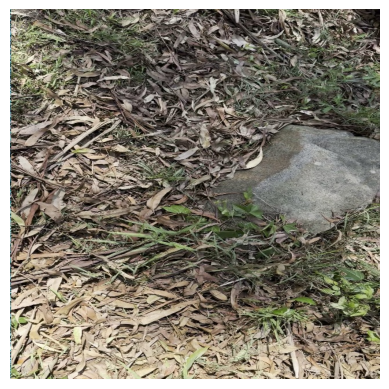

Caption using tuned student model: The image features a grassy field with several leaves scattered around it. There are two leaves visible in the scene, one towards the left side and another towards the right side of the image. Additionally,


In [ ]:
# --- 5. Run & save “before training” inference ---
sample_image = os.path.join(IMAGE_ROOT, "frame_IMG_4977_00002.jpg")
show_image(sample_image)
print("Caption using tuned student model:", generate_caption(sample_image, model, feature_extractor, tokenizer, decode=True))

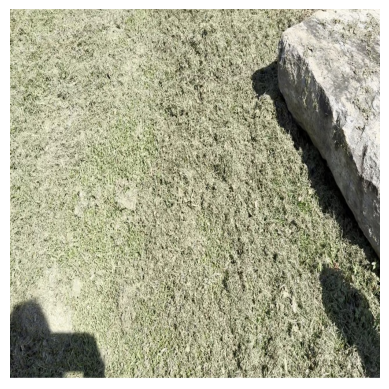

Caption using tuned student model: The image features a grassy field surrounded by green grass. There is one large rock located towards the left side of the field. The rock appears to be relatively small compared to the surrounding area. Additionally


In [ ]:
# --- 5. Run & save “before training” inference ---
IMAGE_ROOT = "/content/drive/MyDrive/EnigmaAI/mini_dataset_training/images"
sample_image = os.path.join(IMAGE_ROOT, "frame_IMG_4953_00005.jpg")
show_image(sample_image)
print("Caption using tuned student model:", generate_caption(sample_image, model, feature_extractor, tokenizer, decode=True))